# Simulating stock price dynamics using geometric Brownian motion

## How to do it

### 1. Import the libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'pandas'

### 2. Download data from Yahoo Finance

In [2]:
df = yf.download(
    'IBM',
    start='2021-01-01',
    end='2022-01-31'
)

[*********************100%***********************]  1 of 1 completed


### 3. Calculate and plot daily returns

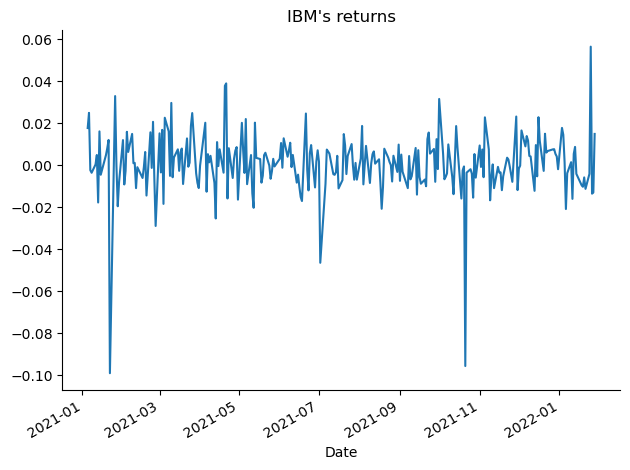

In [3]:
returns = df['Adj Close'].pct_change().dropna()
returns.plot(title="IBM's returns")

sns.despine()
plt.tight_layout()

### 4. Split data into the training and test sets

In [4]:
train = returns['2021']
test = returns['2022']

### 5. Specify the parameters of the simulation

In [5]:
T = len(test)
N = len(test)
S_0 = df.loc[train.index[-1], 'Adj Close']
N_SIM = 100
mu = train.mean()
sigma = train.std()

### 6. Define the function used for simulations

In [6]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    """ 
    Function used to simulate stock returns using Geometric Brownian Motion
    
    Parameters
    -----------

    s_0: float
        initial stock price
    mu: float
        Drift coefficient
    sigma: float
        Diffusion coefficient
    n_sims: int
        Number of simulations paths
    dt : float
        Time step fraction
    T : float
        Length of the forecast horizon, same as unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x N) containing the simulation results
        Rows represent sample paths, white columns point in time
    """

    np.random.seed(random_seed)

    dt = T/N    # time increment
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))  # Brownian increments
    # In the matrix of Brownian increments, each row represents one sample path
    W = np.cumsum(dW, axis=1)   # calculate the Brownian path by running a cumulative sum over the row

    # create an array of evenly spaced values within an interval (the horizon of simulation) for a matirx of time steps
    time_step = np.linspace(dt, T, N)   
    # we broadcast the array to the intended shape using np.broadcast_to
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * W)    # simulate the stock price path using closed-form formula554
    S_t = np.insert(S_t, 0, s_0, axis=1)    # insert the initial stock price at the beginning of each row

    return S_t

### 7. Run the simulations and store the results in a DataFrame

In [7]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
sim_df = pd.DataFrame(np.transpose(gbm_simulations), index=train.index[-1:].union(test.index))

### 8. Create a DataFrame with the average value for each time step and the corresponding actual stock price.

In [8]:
res_df = sim_df.mean(axis=1).to_frame()
res_df = res_df.join(df['Adj Close'])
res_df.columns = ['simulation_average', 'adhj_close_price']
res_df.head()

,simulation_average,adhj_close_price
Date,,
2021-12-31,124.106911,124.106911
2022-01-03,124.358414,126.316795
2022-01-04,124.563792,128.155304
2022-01-05,124.662915,128.341003
2022-01-06,125.027014,125.666847


### 9. Plot the results of the simulation

<Axes: title={'center': "Simulation's reuslts"}, xlabel='Date'>

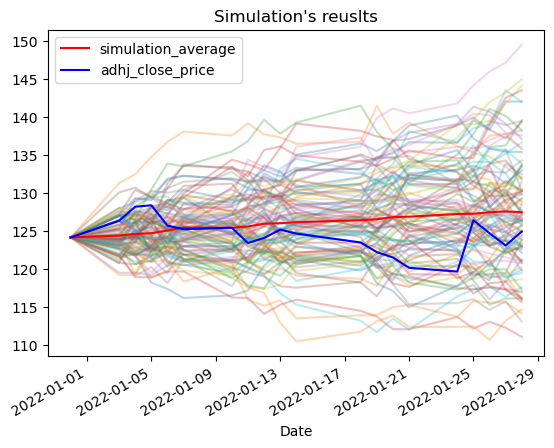

In [9]:
ax = sim_df.plot(
    alpha=0.3,
    legend=False,
    title="Simulation's reuslts"
)
res_df.plot(ax=ax, color=['red', 'blue'])

## There's more

In [10]:
# we time the initial verion of the fucntion
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

73.3 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
# the new function is defined as follows

def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    """ 
    Function used to simulate stock returns using Geometric Brownian Motion

    Parameters
    -----------
    s_0: float
        initial stock price
    mu: float
        Drift coefficient
    sigma: float
        Diffusion coefficient
    n_sims: int
        Number of simulations paths
    dt : float
        Time increment, mosg commonly a day
    T : float
        Length of the forecast horizon, same as unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance
    
    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results
        Rows represent sample paths, white columns point in time
    """

    np.random.seed(random_seed)

    # time increment
    dt = T/N

    # Brownian
    if antithetic_var:
        dw_ant = np.random.normal(scale=np.sqrt(dt), size=(int(n_sims/2), N + 1))
        dw = np.concatenate((dw_ant, - dw_ant), axis=0)
    else:
        dw = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N + 1))
    
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dw, axis=1))

    S_t[:, 0] = s_0

    return S_t

In [12]:
# First, we run the simulations without antithetic variates
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

55.6 µs ± 2.71 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
# Then, we run the simulations with antithetic variables
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

45.1 µs ± 2.78 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Pricing European options using simulations

## How to do it

### 1. Import the libraries

In [14]:
import numpy as np
from scipy.stats import norm

In [15]:
%load_ext autoreload
%autoreload 2
from monte_carlo_utils import simulate_gbm

### 2. Define the parameters for the valuation

In [16]:
S_0 = 100       # initial stock price
K = 100         # strike price, the one we can buy/sell for at maturity
r = 0.05        # annual risk-free rate
sigma = 0.50    # underlying stock volatility (annualized)
T = 1   # 1 year (time maturity - in years)
N = 252 # 252 trading days in a year (number of simulated sample paths)
dt = T / N # time step
N_SIMS = 1_000_000  # number of simulations
discount_factor = np.exp(-r * T) # discount factor, which is used to calculate the present value of future payoff

### 3. Define the valuation function using the analytical solution

In [17]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    """ 
    Function used for calculating the price of European options using analytical form of the Black-Scholes model.

    Parameters
    -----------
    S_0 : float
        initial stock price
    K : float
        strike price
    T : float
        time to maturity in years
    r : float
        Annualized risk-free rate, continuously compounded
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Can be one of the following: ["call", "put"]
    """

    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    d2 = d1 - sigma * np.sqrt(T)
    if type == "call":
        N_d1 = norm.cdf(d1, 0, 1)
        N_d2 = norm.cdf(d2, 0, 1)
        val = S_0 * N_d1 - K * np.exp(-r * T) * N_d2
    elif type == "put":
        N_d1 = norm.cdf(-d1, 0, 1)
        N_d2 = norm.cdf(-d2, 0, 1)
        val = K * np.exp(-r * T) * N_d2 - S_0 * N_d1
    
    else:
        raise ValueError("Wrong input for type!")
    
    return val

### 4. Valuate the call option using the specified parameters

In [18]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

### 5. Simulate the stock path using the `simulate_gbm` function

In [19]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N)

### 6. Calculate the option's premium

In [20]:
premium = (
    discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
)
premium

21.756178586245806

## There's more

### 1. Calculate the option premium for the European put option using the analytical formula

In [21]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

16.915546662938254

### 2. Define the modified simulation function, which only looks at the terminal values of the simulation paths.

In [22]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, type='call', random_seed=12):
    """ 
    Function used for calculating the price of European options using Monte Carlo simulations.

    Parameters
    -----------
    S_0 : float
        initial stock price
    K : float
        strike price
    T : float
        time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of simulations
    type : str
        Type of the option. Can be one of the following: ["call", "put"]
    random_seed : int
        Random seed for reproducibility
    
    Returns
    -----------
    option_premium : float
        The premium on the toption calculated using Monte Carlo simulations
    """

    np.random.seed(random_seed)
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * rv)

    if type == "call":
        payoff = np.maximum(0, S_T - K)
    elif type == "put":
        payoff = np.maximum(0, K - S_T)
    else:
        raise ValueError("Wrong input for type!")
    
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium


### 3. Run the simulations for the European put option

In [23]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type='put')

16.964270846855452

# Pricing American options with Least Squares Monte Carlo

## How to do it

### 1. Import the libraries

In [24]:
%load_ext autoreload
%autoreload 2
from monte_carlo_utils import (simulate_gbm, black_scholes_analytical, lsmc_american_opton)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np

### 2. Define the parameters

In [26]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1   # 1 year (time maturity - in years)
N = 50 
dt = T / N # time step
N_SIMS = 10 ** 5
discount_factor = np.exp(-r * dt)
OPTION_TYPE = "put"
POLY_DEGREE = 5

### 3. Simulate the stock prices using GBM

In [27]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N)

### 4. Calculate the payoff matrix

In [28]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))
payoff_matrix

array([[ 4.        ,  3.57492426,  2.87179848, ..., 11.39112485,
        12.76097511, 12.4881406 ],
       [ 4.        ,  5.00934866,  4.37022234, ...,  1.95771106,
         3.42131558,  3.82500872],
       [ 4.        ,  5.09138384,  5.22245808, ...,  2.43122276,
         2.03091226,  2.72442284],
       ...,
       [ 4.        ,  6.05954755,  2.95562539, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.        ,  5.03240201,  5.51664788, ...,  1.49184962,
         0.91849964,  1.81027711],
       [ 4.        ,  3.81199439,  4.96641199, ...,  2.23777185,
         4.3232401 ,  2.25535094]])

### 5. Define the value matrix and fill in the last column (time T)

In [29]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]
value_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 12.4881406 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  3.82500872],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  2.72442284],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.81027711],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  2.25535094]])

### 6. Iteratively calculate the continuation value and the value vector in the given time

In [30]:
for t in range(N - 1, 0, -1):
    regression = np.polyfit(
        gbm_sims[:, t],
        value_matrix[:, t + 1] * discount_factor,
        POLY_DEGREE
    )
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

### 7. Calculate the option’s premium

In [31]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
option_premium

4.464758780741195

### 8. Calculate the premium of a European put with the same parameters

In [32]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

3.84430779159684

### 9. As an extra check, calculate the prices of the American and European call options

In [33]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma)
american_call_price = lsmc_american_opton(
    S_0=S_0, K=K, T=T, N=N, r=r, sigma=sigma, n_sims=N_SIMS, option_type="call", poly_degree=POLY_DEGREE
)
print(f"European call's price: {european_call_price:.3f}")
print(f"American call's price: {american_call_price:.3f}")

European call's price: 2.174
American call's price: 2.097


# Pricing American options using QuantLib

## Getting ready

This setup is the same as Step 2 in the previous recipe.

In [34]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
N = 50
N_SIMS = 10 ** 5
OPTION_TYPE = "put"
POLY_DEGREE = 5

## How to do it

### 1. Import the libraries

In [35]:
import QuantLib as ql

### 2. Specify the calendar and the day-counting convention

In [36]:
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

### 3. Specify the valuation data and the expiry date of the option

In [37]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date = ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [38]:
T = day_counter.yearFraction(valuation_date, expiry_date)
print(f"Time to expiry in years: {T}")

Time to expiry in years: 1.0


### 4. Define the option type (call/put), type of exercise and the payoff

In [39]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put

exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

### 5. Prepare the market-related data

In [40]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

### 6. Specify the market-related curves

In [41]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(
    0, ql.TARGET(), ql.QuoteHandle(sigma), day_counter
)
risk_free_rate = ql.FlatForward(
    0, ql.TARGET(), ql.QuoteHandle(r), day_counter
)

### 7. Plug in the market-related data into the BS process

In [42]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility)
)

### 8. Instantiate the Monte Carlo engine for the American options

In [43]:
engine = ql.MCAmericanEngine(
    bs_process, "pseudorandom", timeSteps=N,
    polynomOrder=POLY_DEGREE,
    seedCalibration=42,
    requiredSamples=N_SIMS
)

### 9. Instantiate the option object and set its pricing engine

In [44]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

### 10. Calculate the option’s premium

In [45]:
option_premium_ql = option.NPV()
option_premium_ql

4.46778458172744

In [46]:
print(f"The value of the American {OPTION_TYPE} option is : {option_premium_ql:.3f}")

The value of the American put option is : 4.468


## There's more

In [47]:
u_0 = u.value()     # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0)     # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

Delta of the option: -0.89


# Pricing barrier options

## How to do it

### 1. Import the libraries

In [48]:
import numpy as np
from monte_carlo_utils import simulate_gbm

### 2. Define the parameters for the valuation

In [69]:
S_0 = 35
K = 60
BARRIER = 65
r = 0.06
sigma = 0.2
T = 1
N = 252
dt = T / N
N_SIMS = 10 ** 5
OPTION_TYPE = 'call'
discount_factor = np.exp(-r * T)

### 3. Simulate the stock path using the simulate_gbm function

In [50]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

### 4. Calculate the maximum value per path

In [51]:
max_value_per_path = np.max(gbm_sims, axis=1)

### 5. Calculate the payoff

In [52]:
payoff = np.where(max_value_per_path > BARRIER, 
                  np.maximum(0, gbm_sims[:, -1] - K), 
                  0)

### 6. Calculate the option’s premium

In [53]:
premium = discount_factor * np.mean(payoff)
premium

0.019480944042739014

## There's more

### 1. Import the library

In [70]:
import QuantLib as ql

### 2. Specify the calendar and the day counting convention

In [71]:
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

### 3. Specify the valuation date and the expiry date of the option

In [72]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date = ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

#### 4. Define the option type (call/put), type of exercise and the payoff

In [73]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put

exercise = ql.EuropeanExercise(expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

### 5. Prepare the market-related data

In [74]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

### 6. Specify the market-related curves

In [75]:
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(
    0, ql.TARGET(), ql.QuoteHandle(sigma), day_counter
)
risk_free_rate = ql.FlatForward(
    0, ql.TARGET(), ql.QuoteHandle(r), day_counter
)

### 7. Plug in the market-related data into the BS process

In [76]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility)
)

### 8. Instantiate the Monte Carlo engine for barrier options

In [78]:
engine = ql.MCBarrierEngine(
    bs_process, 'PseudoRandom', timeSteps=N,
    seed=42,
    requiredSamples=N_SIMS
)

### 9. Instantiate the option object and set its pricing engine

In [79]:
option = ql.BarrierOption(
    ql.Barrier.UpIn,
    BARRIER,
    rebate=0,
    payoff=payoff,
    exercise=exercise
)
option.setPricingEngine(engine)

### 10. Calculate the option’s premium

In [80]:
option_premium_ql = option.NPV()
option_premium_ql

0.019532288841602435

# Estimating Value-at-Risk using Monte Carlo

## How to do it

### 1. Import the libraries

In [81]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns

In [82]:
# set random seed for reproducibility
np.random.seed(42)

### 2. Define the parameters that will be used for this recipe

In [83]:
RISKY_ASSETS = ["AMD", "INTC"]
SHARES = [5, 5]
START_DATE = "2020-01-01"
END_DATE = "2020-12-31"
T = 1
N_SIM = 10 ** 5

### 3. Download data from Yahoo Finance

In [84]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE)

[*********************100%***********************]  2 of 2 completed


In [85]:
df.head()

Adj Close                 Close                  High             \
                  AMD       INTC        AMD       INTC        AMD       INTC   
Date                                                                           
2020-01-02  49.099998  54.760353  49.099998  60.840000  49.250000  60.970001   
2020-01-03  48.599998  54.094292  48.599998  60.099998  49.389999  60.700001   
2020-01-06  48.389999  53.941277  48.389999  59.930000  48.860001  60.200001   
2020-01-07  48.250000  53.041206  48.250000  58.930000  49.389999  59.799999   
2020-01-08  47.830002  53.077217  47.830002  58.970001  48.299999  59.320000   

                  Low                  Open               Volume            
                  AMD       INTC        AMD       INTC       AMD      INTC  
Date                                                                        
2020-01-02  46.630001  60.220001  46.860001  60.240002  80331100  18056000  
2020-01-03  47.540001  59.810001  48.029999  59.810001  73127400  15293900  
2020-01-06  47.860001  59.330002  48.020000  59.590000  47934900  17755200  
2020-01-07  48.040001  58.889999  49.349998  59.779999  58061400  21876100  
2020-01-08  47.139999  58.520000  47.849998  58.889999  53767000  23133500

### 4. Calculate daily returns

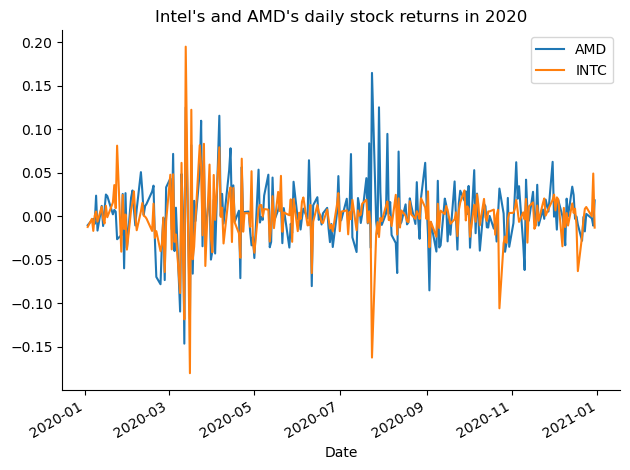

In [86]:
returns = df['Adj Close'].pct_change().dropna()
returns.plot(title="Intel's and AMD's daily stock returns in 2020")

sns.despine()
plt.tight_layout()

In [88]:
print(f'Correlation between returns : {returns.corr().values[0, 1]:.2f}')

Correlation between returns : 0.50


### 5. Calculate the covariance matrix

In [89]:
cov_mat = returns.cov()
cov_mat

,AMD,INTC
AMD,0.001475,0.000652
INTC,0.000652,0.001137


### 6. Perform the Cholesky decomposition of the covariance matrix

In [91]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.0384075 , 0.        ],
       [0.01697691, 0.0291255 ]])

### 7. Draw correlated random numbers from Standard Normal distribution

In [92]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

### 8. Define metrics used for simulations

In [94]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = df['Adj Close'].values[-1, :]
P_0 = np.sum(SHARES * S_0)

### 9. Calculate the terminal price of the considered stocks

In [95]:
S_T = S_0 * np.exp(
    (r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv
)

### 10. Calculate the terminal portfolio value and calculate the portfolio returns

In [96]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

### 11. Calculate VaR

In [98]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f"1-day VaR with {100-x}% confidence: {-y:.2f}$")

1-day VaR with 99.99% confidence: 2.12$
1-day VaR with 99.9% confidence: 1.57$
1-day VaR with 99.0% confidence: 0.96$


### 12. Present the results on a graph

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_93400/554925849.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(P_diff, kde=False)


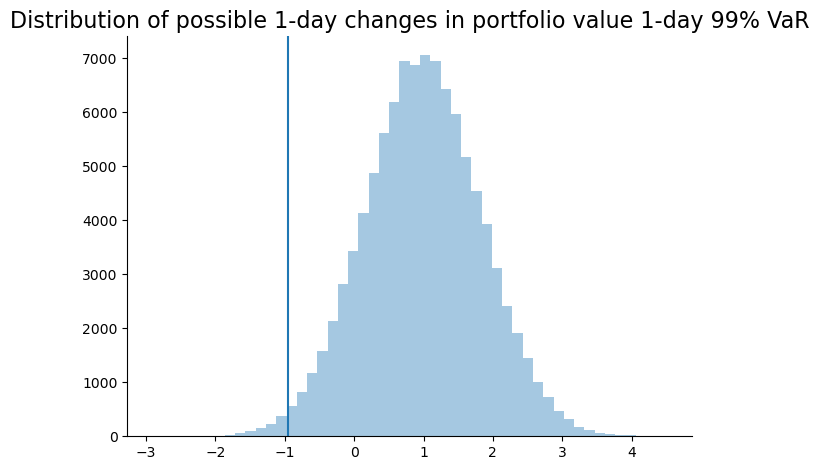

In [101]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title("""Distribution of possible 1-day changes in portfolio value 1-day 99% VaR""", fontsize=16)
ax.axvline(var[2], 0, 10000)

sns.despine()
plt.tight_layout()

## There's more

In [102]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted <= var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying expected shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 0.39$, and the accompanying expected shortfall is 0.74$.
